In [2]:
import requests
from bs4 import BeautifulSoup
import lxml
import numpy as np
import pandas as pd

from datetime import datetime, timedelta, date
import yfinance as yf
import matplotlib.pyplot as plt
from pandas_datareader import data
#import nltk
#nltk.download()

In [ ]:

callParticipantsList = []
preparedRemarksContentList = []
questionAnswerContentList = []
companyNameList = []
tickerList = []
dateList = []
timeList=[]
quarterList=[]

listofurls = []

## This query took us 10hours for 30'000 transcripts (now the for loop is set to only 5 webpages
## this is in case you want to run it, otherwise we saved the output lower and you can reuse it)

#This code was inspired by Christine Hwang and heavily modified to suit our needs
#go to each page and get a list of link to single transcripts
for x in range(1,5):
    url = 'https://www.fool.com/earnings-call-transcripts/?page='+str(x)
    response = requests.get(url)
    page = response.text
    soup = BeautifulSoup(page, "lxml")

    for a in soup.find(class_="content-block listed-articles recent-articles m-np").find_all('a', href=True):
        listofurls.append('https://www.fool.com'+str(a['href']))

print(len(listofurls), 'length of list of URLs')
print(len(set(listofurls)), 'length of list of unique URLs')


#writing list
with open('list_of_urls.txt', 'w') as f:
    for item in listofurls:
        f.write("%s\n" % item)


# open txt file of URLs for each trancript and make it a list (truncated or not), return a list URLs (without duplicates)
my_file = open("list_of_urls.txt", "r")
content_list = my_file.read().splitlines()
print(len(content_list), 'content list')
truncatedList = content_list[:]
print(len(truncatedList),'truncated')
print(len(list(set(truncatedList))), 'length of unique urls')
print('Unique URls will be used')
truncatedList = list(set(truncatedList))


indic =  0
for x in truncatedList:
    
    indic += 1
    print(indic)
    url = str(x)
    response = requests.get(url)
    page = response.text
    soup = BeautifulSoup(page, "lxml")

    try:
        companyName = [soup.find(class_='tailwind-article-body').find_all('p')[1].find('strong').text]

        for x in companyName:
            companyNameList.append(x)

    except:
        print('Company name : raised error, i keep going')
        companyNameList.append(0)
        
    #I use error habdling as some pages have different acces path to data
    try:
        ticker = [soup.find(class_='tailwind-article-body').find_all('p')[1].find(class_='ticker-symbol').text.replace(')',"").replace('(',"")]

        for x in ticker:
            tickerList.append(x)

    except:
        print('Ticker : raised error, i keep going')
        tickerList.append(0)

    try:
        date = [soup.find(class_='tailwind-article-body').find_all('p')[1].find(id='date').text]

        for x in date:
            dateList.append(x)

    except:
        print('Date : raised error, i keep going')
        dateList.append(0)

    try:
        time = [soup.find(class_='tailwind-article-body').find_all('p')[1].find(id='time').text]

        for x in time:
            timeList.append(x)
    except:
        print('Time : raised error, i keep going')
        timeList.append(0)

    try: 

        quarter = [' '.join(soup.find(class_='md:w-3/4 md:pr-48px').find('header').text.split()[-5:-3])]

        for x in quarter:
            quarterList.append(x)
    
    except:
        print('Quarter : raised error, i keep going')
        quarterList.append(0)

    namesList = []
    rolesList = []

    try:
        for name in (soup.find(class_='tailwind-article-body').find_all('h2')[-1].find_all_next('strong')):
            namesList.append(name.text)
        for role in (soup.find(class_='tailwind-article-body').find_all('h2')[-1].find_all_next('em')):
            rolesList.append(role.text)
        callParticipants = [list(zip(namesList, rolesList))]
        for x in callParticipants:
            callParticipantsList.append([x])
    except: 
        print('callParticipantsList : raised error, i keep going')
        callParticipantsList.append([0])

    try:
        toc = []
        for x in soup.find(class_='tailwind-article-body').find_all('h2'):
            #take a list of all the categories of the call in h2 (html)
            toc.append(x.text)

        if 'Questions & Answers:' or 'Questions and Answers:'in toc:
            qanda = []
            #doesn't work if start immediately with QA see netflix case Q1 2022
            for div in soup.find(class_='tailwind-article-body').find_all('h2')[2].find_all_next('p'):
                #check why find_all_next stays blank
                #creates a list for all paragraphs happening for the QA part of the call
                qanda.append(div.text)

            for x in qanda:
                if 'Duration:' in x:
                    #if duration of call is mentionned store its location inside in duration Placement
                    durationPlacement = qanda.index(x)
                
            # we need to get rid of bottom text, as duration is at the end we delete what comes after
            questionAnswerContentList.append(qanda[:durationPlacement])


        else:
            #if non-existing QA append 0
            questionAnswerContentList.append(0)  
    except:
            print('questionAnswerContentList : raised error, i keep going')  
            questionAnswerContentList.append(0)

    try:
        preparedRemarks = []
        prIndex = []
        #select all content in p after word operator
        for div in soup.find(class_='tailwind-article-body').find_all('p')[4:]:
            #add the content of each paragraph to a list
            preparedRemarks.append(div.text)
        #prev prindex here, only showed first line now moved it to top and it works fine
        for x in preparedRemarks:
            # or or '[Operator instructions]'
            if 'Operator' in x:
                #find index of operator and store it in prIndex
                prIndex.append(preparedRemarks.index(x))
            else:
                None
        if len(prIndex) == 0:
            None
        else:
            #operator starts the QA section always so we can stop prepared remarks just before second occurence of word operator
            preparedRemarksContent = [preparedRemarks[:prIndex[1]]]

        for x in preparedRemarksContent:
            preparedRemarksContentList.append(x)
    except:
        print('preparedRemarksContentList : raised error, i keep going')
        preparedRemarksContentList.append(0)
    

happy_data = pd.DataFrame(
                            {'Ticker': tickerList[:],
                             'Company': companyNameList[:], 
                             'Quarter': quarterList[:], 
                             'Date': dateList[:],
                             'Time': timeList[:], 
                             'Prepared comments': preparedRemarksContentList[:], 
                             'Q&A': questionAnswerContentList[:],
                             'Call participant': callParticipantsList})

counter = 0
for i in list(happy_data.columns):
    for x in happy_data[i]:
        if x == 0:
            counter += 1
print(counter, ' = Number of missing values to be cleaned')
print(len(happy_data), 'Lenght of raw database')


#cleaning data for missing values
for i in list(happy_data.columns):
    happy_data = happy_data[happy_data[i] != 0]
print(len(happy_data), 'Length of clean database')

#save
happy_data.to_pickle('happy_data_partially_clean.pkl')


In [ ]:
#reopen

full_data = pd.read_pickle('happy_data_partially_clean.pkl')

full_data = full_data.set_index('Ticker').sort_index()[['Company', 'Quarter', 'Date', 'Time', 'Prepared comments', 'Q&A', 'Call participant']]
print(len(full_data),':Length before dropping null values of date')
#droping empty values
full_data = full_data.drop(full_data.loc[full_data['Date']==''].index)
TickerList = list(full_data.index)
DateList = list(full_data.Date)
print(len(full_data), ':Length after dropping null values of date')

def to_abb(x):

    """
    Function tranforms strings variables of data to a standardized written form
    Not pretty code, but it makes the following standardization possible
    """

    x=x.replace(',', '').replace('.', '')
    x=x.replace('January', 'Jan').replace('February','Feb')
    x=x.replace('March', 'Mar').replace('April', 'Apr')
    x=x.replace('June', 'Jun').replace('July', 'Jul')
    x=x.replace('August', 'Aug').replace('September', 'Sep')
    x=x.replace('October', 'Oct').replace('November', 'Nov')
    x=x.replace('December', 'Dec')
    return x

for i in range(len(DateList)):
    #removing the boring comma in date format and formating month to abbreviated form
    temp = to_abb(str(DateList[i]))
    DateList[i] = temp
    #changing format from string to timestamps
    DateList[i] = datetime.strptime(DateList[i], '%b %d %Y')

full_data['Date'] = DateList

full_data.reset_index(inplace=True)

# attempt to clean names/functions/numbers 

#looks like it works for now
def clean_text(dataframe, column, names):

    ''' 
    this function cleans all the stopwords, numbers,  names and functions from a text. 
    dataframe :  name of dataframe to clean
    column : column of dataframe to clean
    names :  list of names to clean from text (it also includes positions of employees)

    '''
    import string
    from string import digits
    import nltk
    #NEED TO INSTALL STOPWORDS BEFORE USING FUNCTION
    #nltk.download()
    from nltk.corpus import stopwords
    stop_words = stopwords.words('english')

    for i in range(len(dataframe)):

        NamesList = []
        temp_name_list = []
        cleanedNames_text = []

        temp_list_name = str(dataframe[names][i][0]).translate(str.maketrans('', '', string.punctuation)).lower().split(" ")

        #create a list of names/functions without initials
        for x in temp_list_name:
            if len(x) > 2:
                NamesList.append(x)
            NamesList.append('operator')
            NamesList.append('instructions')

        dataframe.at[i, names] = NamesList


        #use created list to take out all the names and functions from text of Q/A or prepared comments
        #first take out punctuation and upper case letters

        temp_list_text = str(dataframe[column][i]).translate(str.maketrans('', '', string.punctuation)).lower()
        temp_list_text = temp_list_text.translate(str.maketrans('', '', digits)).split(" ")
        cleanedNames_text = [word for word in temp_list_text if word not in NamesList]
        cleanedstopwords_text = [word for word in cleanedNames_text if word not in stop_words]
        #the next 2 lines would be used if we only want to keep english words
        #allcleaned = [word for word in cleanedstopwords_text if word not in set(nltk.corpus.words.words())]
        #dataframe.at[i, column] = " ".join(allcleaned)
        dataframe.at[i, column] = " ".join(cleanedstopwords_text)
        print(i)

clean_text(full_data, 'Prepared comments', 'Call participant')
clean_text(full_data, 'Q&A', 'Call participant')

#save
full_data.to_pickle('full_data_clean_10k.pkl')


In [3]:

#reopen
full_data = pd.read_pickle('full_data_clean_10k.pkl')

#adding a column that returns true if the earning call happened after exchange quoting hours
full_data['after_mkt'] = ['p.m.' in full_data['Time'].iloc[x] for x in range(len(full_data))]

#API doens't let us do big queries so we try to bypass limit by looping over smaller queries
print('number of distinct tickers:', len(set(full_data['Ticker'])))
#We need multiple queries for 2828 tickers, we iterate by 500 tickers


#API doens't let us do big queries so we try to bypass limit by looping over smaller queries
print('number of distinct tickers:', len(set(full_data['Ticker'])))
#We need multiple queries for 2828 tickers, we iterate by 500 tickers


number of distinct tickers: 3661
number of distinct tickers: 3661


In [ ]:

####################################################################################

#API doens't let us do big queries so we try to bypass limit by looping over smaller queries
print('number of distinct tickers:', len(set(full_data['Ticker'])))
#We need multiple queries for +3000  tickers, we iterate by 500 tickers

listtickers = list(sorted(set(full_data['Ticker'])))[:]
tot = len(listtickers)

rest = len(listtickers) % 500
print('number of queries for last iteration :', rest)
x = pd.DataFrame()

for i in range(500,len(listtickers),500):
    print('getting', i)

    tempdat = yf.download(listtickers[i-500:i], start="2015-12-31", end="2022-05-13")[['Adj Close']].T
    #tempdat.droplevel(0)
    x = pd.concat([x, tempdat])

last_iteration = yf.download(listtickers[tot - rest:tot], start="2015-12-31", end="2022-05-13")[['Adj Close']].T
x = pd.concat([x, last_iteration])


####################################################################################

#save
x.to_pickle('YF.pkl')



In [6]:
#check if we skip this part ?

x = pd.read_pickle('YF.pkl')
#we have a few days (=10) that return no value we delete them (unlikely to affect final result)
print('tickers:',len(x))
print('Dates', len(x.columns))
x.dropna(axis=1, how='all', inplace=True)
x.dropna(axis=0, how='any', inplace=True)
print('Tickers:', len(x))
print('Dates:', len(x.columns))
x
#won't have any Nan this way, if it works with next cells keep it that way

tickers: 3661
Dates 1614
Tickers: 2479
Dates: 1604


Date            2021-09-28  2021-09-29  2021-09-30  2021-10-01  2021-10-04  \
Adj Close A     159.491074  159.590820  157.127136  155.591080  152.159592   
          AA     50.868908   50.469780   48.833351   49.661545   49.072830   
          AAIC    3.760000    3.710000    3.700000    3.710000    3.700000   
          AAL    21.430000   21.010000   20.520000   21.650000   21.389999   
          AAOI    7.050000    7.040000    7.180000    7.190000    6.810000   
...                    ...         ...         ...         ...         ...   
          ZNGA    7.470000    7.550000    7.530000    7.490000    7.230000   
          ZTS   192.231339  194.445145  193.597504  195.641785  193.148758   
          ZUMZ   43.310001   43.110001   39.759998   41.259998   41.689999   
          ZWS    63.630001   65.199997   64.290001   64.370003   64.949997   
          ZYXI   10.718182   10.527273   10.354545   10.109091    9.845455   

Date            2021-10-05  2021-10-06  2021-10-07  2021-10-08  2021-10-11  \
Adj Close A     152.828705  153.447891  155.115707  152.269455  149.822678   
          AA     48.943111   46.947472   46.947472   45.929691   47.186951   
          AAIC    3.730000    3.730000    3.750000    3.780000    3.850000   
          AAL    21.469999   20.540001   20.170000   20.070000   20.129999   
          AAOI    6.870000    6.870000    6.900000    6.790000    6.810000   
...                    ...         ...         ...         ...         ...   
          ZNGA    7.280000    7.290000    7.490000    7.430000    7.370000   
          ZTS   195.911026  195.232925  198.453888  197.327057  197.097687   
          ZUMZ   40.240002   40.209999   41.610001   40.799999   39.529999   
          ZWS    33.049999   33.849998   37.000000   36.459999   35.860001   
          ZYXI   10.027273   10.081818   10.200000   10.145455   10.154545   

Date            ...  2021-09-14  2021-09-15  2021-09-16  2021-09-17  \
Adj Close A     ...  171.979050  173.345535  172.836853  173.495163   
          AA    ...   47.895401   51.567383   49.302330   48.723595   
          AAIC  ...    3.790000    3.770000    3.760000    3.770000   
          AAL   ...   19.209999   19.379999   19.889999   19.730000   
          AAOI  ...    7.210000    7.280000    7.460000    7.460000   
...             ...         ...         ...         ...         ...   
          ZNGA  ...    8.190000    8.050000    7.990000    8.010000   
          ZTS   ...  202.981216  203.390076  202.203400  197.935364   
          ZUMZ  ...   37.560001   38.450001   39.540001   42.799999   
          ZWS   ...   62.490002   63.759998   62.880001   61.480000   
          ZYXI  ...   11.136364   11.081818   11.154545   11.445455   

Date            2021-09-20  2021-09-21  2021-09-22  2021-09-23  2021-09-24  \
Adj Close A     170.901810  171.001572  171.999008  172.328171  171.959106   
          AA     48.354397   45.500629   47.845512   48.454182   48.384335   
          AAIC    3.710000    3.720000    3.770000    3.780000    3.780000   
          AAL    20.330000   19.760000   20.520000   20.900000   21.389999   
          AAOI    6.970000    6.780000    6.980000    7.160000    7.240000   
...                    ...         ...         ...         ...         ...   
          ZNGA    7.740000    7.660000    7.600000    7.640000    7.650000   
          ZTS   198.064987  200.448303  200.787384  204.137970  204.157913   
          ZUMZ   40.900002   39.849998   41.099998   41.880001   41.360001   
          ZWS    61.160000   60.150002   61.509998   62.680000   63.459999   
          ZYXI   11.200000   11.300000   11.318182   11.218182   10.872727   

Date            2021-09-27  
Adj Close A     165.954498  
          AA     51.447643  
          AAIC    3.760000  
          AAL    21.469999  
          AAOI    7.240000  
...                    ...  
          ZNGA    7.560000  
          ZTS   197.247299  
          ZUMZ   43.610001  
          ZWS    64.150002  
          ZYXI   

In [7]:

#read

x = x.droplevel(0).T
x = x.sort_values(by='Date')
x = x.reset_index()
x

,Date,A,AA,AAIC,AAL,AAOI,AAON,AAP,AAPL,AAT,...,ZBRA,ZEN,ZEUS,ZG,ZION,ZNGA,ZTS,ZUMZ,ZWS,ZYXI
0,2015-12-30,39.961281,23.548573,6.777791,40.901627,17.799999,22.737114,146.655518,24.778051,33.057686,...,69.449997,26.510000,11.111731,26.420000,24.438978,2.68,46.337700,15.530000,18.379999,0.379550
1,2015-12-31,39.728474,23.335787,6.721900,40.471588,17.160000,22.304852,145.793411,24.302439,32.431873,...,69.650002,26.440001,11.277287,26.040001,24.287739,2.68,46.011238,15.120000,18.120001,0.397204
2,2016-01-04,38.664230,22.957499,6.726981,39.095455,16.290001,21.277021,147.469162,24.323219,31.797623,...,66.489998,26.059999,11.423362,24.510000,23.762840,2.58,45.387127,15.160000,18.320000,0.326590
3,2016-01-05,38.531200,21.917198,6.854000,38.722763,16.080000,21.228992,146.461777,23.713696,32.787064,...,64.820000,25.680000,11.355194,24.040001,23.504839,2.56,46.097660,15.310000,17.719999,0.361897
4,2016-01-06,38.702248,20.356752,6.808274,39.401257,16.049999,20.835154,142.587128,23.249626,32.753239,...,62.230000,25.309999,11.355194,23.879999,22.819798,2.57,46.107254,15.080000,17.000000,0.388377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1599,2022-05-06,121.080002,61.040001,3.100000,17.840000,2.530000,52.110001,202.860001,157.279999,34.380001,...,342.589996,113.879997,33.279999,37.369999,55.910000,8.08,169.210007,35.560001,28.860001,6.240000
1600,2022-05-09,113.110001,54.209999,3.060000,16.320000,2.210000,54.009998,202.639999,152.059998,33.150002,...,328.540009,99.139999,30.639999,36.520000,55.160000,7.69,161.809998,34.180000,27.440001,6.200000
1601,2022-05-10,116.639999,55.840000,3.020000,16.570000,2.280000,53.169998,202.899994,154.509995,32.340000,...,325.839996,100.699997,30.930000,36.090000,53.889999,7.58,162.649994,33.869999,27.990000,5.900000
1602,2022-05-11,113.989998,56.660000,3.020000,15.970000,2.120000,50.200001,201.070007,146.500000,31.920000,...,314.500000,98.870003,30.350000,34.860001,53.450001,7.66,159.899994,32.639999,27.959999,6.090000


In [ ]:

list_quote = []

for i in range(len(full_data)):

    #this is pm/am section : differnce is computed with ppct change, here we collect absolut price around transcript
    
    #find date of transcript
    date = full_data['Date'].iloc[i]
    #find ticker of company
    ticker = full_data['Ticker'].iloc[i]
    #find index position of this transcript for that company
    #we will take prices around that index, to get prices around transcript
    date_index = x[x['Date']==date].index
    #date_index is a single element list of index, we take first and unique element
    try:
        date_index = date_index[0]
        #date_index is the day index of prices the day of transcript
        date_index_start = date_index - 5
        #date_index_start is the index of 5 quoting day before transcript, stop is the index 20 quoting days later
        date_index_stop = date_index + 90
        #time to collect prices and append them to a list
        list_quote.append(list(x[ticker].iloc[date_index_start:date_index_stop+1]))
    except: 
        list_quote.append(0)
    #we collected 96 prices around transcript


In [ ]:

df_quote = pd.DataFrame({ 'list_quote': list_quote[:]})
full_data['quote'] = df_quote

print('len transcript', len(full_data))
for i in range(len(full_data)):
    if 'nan' in full_data['quote']:
        full_data = full_data.drop(i)
        
print('len transcript', len(full_data))
full_data = full_data[full_data['quote']!=0]
full_data.reset_index(drop=True, inplace=True)
print('len transcript', len(full_data))


#now we calculate pct change taking into account the fact that some earning call happened before market opens 

pct_change = []

for i in range(len(full_data)):

    temp_list= []

    if full_data['after_mkt'].iloc[i] == True:
        for a in full_data.at[i, 'quote']:
            transcript_price = full_data['quote'].iloc[i][5]
            temp_list.append(a/transcript_price - 1)

        pct_change.append(temp_list[1:])

    else:

        for a in full_data.at[i, 'quote']:
            transcript_price = full_data['quote'].iloc[i][4]
            temp_list.append(a/transcript_price - 1)

        pct_change.append(temp_list[:])
        # we appended strating from different index so we have the pct change coming just after transcript
        # at the same index 

full_data['pct_change'] = pct_change

#################

print(len(full_data))
nan_list = []
for i in range(len(full_data)):
    try:
        if np.isnan(full_data.iloc[i]['quote'][0]):
        
            nan_list.append(False)
        else:
            nan_list.append(True)
    except:
        nan_list.append(False)

        
#dropping the quote which include nan, so delisted stocks
full_data = full_data[nan_list]
print(len(full_data), 'if same length as before remove cuz nan cleaning done twice')

###################

full_data.to_pickle('full_data_final.pkl')



In [ ]:

#getting market cap for each ticker
market_cap = {}
counter = 0
for i in sorted(set(full_data['Ticker'])):
    counter += 1
    print('querying market cap:', counter)
    try:
        market_cap[i] = int(data.get_quote_yahoo(i)['marketCap'])
    except:
        market_cap[i] = 0
        print('market cap not found')


#save
mkt = pd.DataFrame([market_cap])
mkt.to_pickle('mkt.pkl')


In [8]:
#read
mkt = pd.read_pickle('mkt.pkl')
mkt

,A,AA,AAIC,AAL,AAOI,AAON,AAP,AAPL,AAT,AAWW,...,ZBRA,ZEN,ZEUS,ZG,ZION,ZNGA,ZTS,ZUMZ,ZWS,ZYXI
0,36442460160,11267343360,106279096,10983234560,66321844,2671073536,12982469632,2368542081024,2508207872,1979811840,...,17756473344,12141441024,355913664,10409610240,8334784512,8888628224,77602127872,784746624,3327902464,283499232


In [9]:
full_data = pd.read_pickle('full_data_final.pkl')

In [ ]:

#generate a list of market cap (current) in the same order of data frame of transcripts and append it
list_mkt = []
for i in range(len(full_data)):
    try:
        temp = full_data['Ticker'].iloc[i] 
        list_mkt.append(mkt[temp].iloc[0])
    except:
        list_mkt.append(0)

full_data['mktcap'] = list_mkt

full_data = full_data[full_data['mktcap']!=0]

full_data.reset_index(inplace=True, drop=True)

df = full_data
df.to_pickle('x.pkl')
df = pd.read_pickle('x.pkl')
#droping values where data queries generated an empty list, or less than 95 observation, check indexing
print(len(df))
df = df[df['quote'].map(lambda d: len(d)) > 0]
print(len(df))
df = df[df['quote'].map(lambda d: len(d)) >= 95]
df.dropna(axis=0, inplace=True)
print(len(df))
df.reset_index(inplace=True)

df.to_pickle('df_before_graph.pkl')


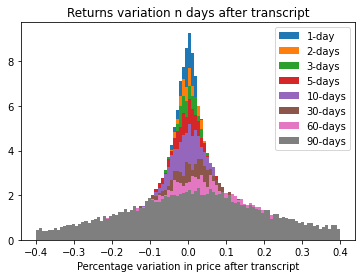

20521 len df #trasncript


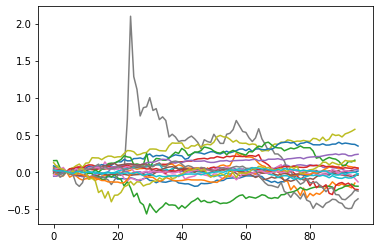

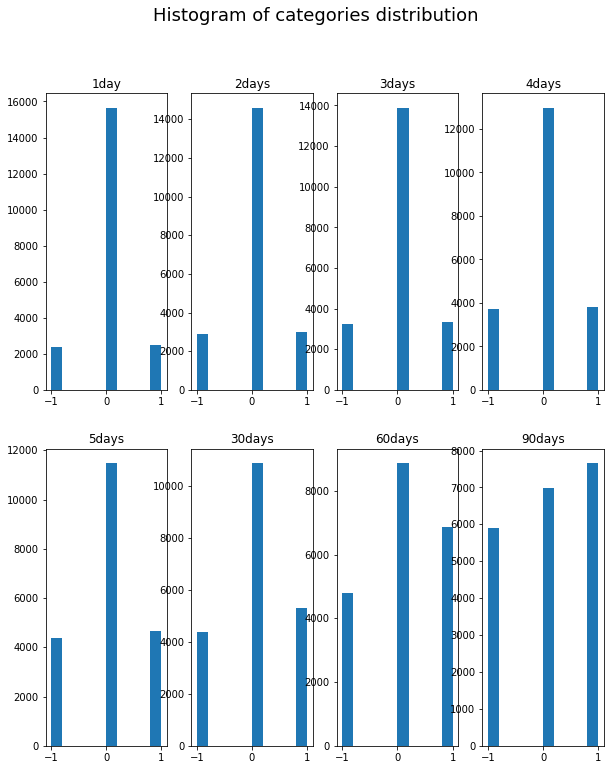

In [10]:

##checking if transcript day is always placed correctly in the list : perfect o% is always in position 4
## index 4 also for transcripts for which earning call happened before market opening
# so we dropped a value preceding trancript day, in order to have same indexing
df = pd.read_pickle('df_before_graph.pkl')
counter = 0
for i in range(len(df)):
    if df['pct_change'].iloc[i][4] != 0:
        counter += 1
        print('not 2nd')

#generate list of %returns for n days after
day_one_pct = []
day_two_pct = []
day_three_pct = []
day_five_pct = []
day_ten_pct = []
day_30_pct = []
day_60_pct = []
day_90_pct = []


for i in range(len(df)):

    day_one_pct.append(df['pct_change'][i][5])
    day_two_pct.append(df['pct_change'][i][6])
    day_three_pct.append(df['pct_change'][i][7])
    day_five_pct.append(df['pct_change'][i][9])
    day_ten_pct.append(df['pct_change'][i][14])
    day_30_pct.append(df['pct_change'][i][34])
    day_60_pct.append(df['pct_change'][i][64])
    day_90_pct.append(df['pct_change'][i][94])


#this result is sensible, the more time we have, the most likely it is to have a deviation from value in t0

plt.hist(day_one_pct, bins=100, label='1-day', density=True, range=(-0.4, 0.4))
plt.hist(day_two_pct, bins=100, label='2-days', density=True, range=(-0.4, 0.4))
plt.hist(day_three_pct, bins=100, label='3-days', density=True, range=(-0.4, 0.4))
plt.hist(day_five_pct, bins=100, label='5-days', density=True, range=(-0.4, 0.4))
plt.hist(day_ten_pct, bins=100, label='10-days', density=True, range=(-0.4, 0.4))
plt.hist(day_30_pct, bins=100, label='30-days', density=True, range=(-0.4, 0.4))
plt.hist(day_60_pct, bins=100, label='60-days', density=True, range=(-0.4, 0.4))
plt.hist(day_90_pct, bins=100, label='90-days', density=True, range=(-0.4, 0.4))
plt.xlabel('Percentage variation in price after transcript')
plt.legend()
plt.title('Returns variation n days after transcript')
plt.show()
plt.savefig('Returns_histogram.png')

days = np.arange(-2,60)
length = []
print(len(df), 'len df #trasncript')
for i in np.random.randint(0, 5000, size=20):
    plt.plot(np.arange(len(df['pct_change'].iloc[i])), df['pct_change'].iloc[i])
plt.savefig('drift_path.png')


cat_1_day = []
cat_2_day = []
cat_3_day = []
cat_5_day = []
cat_10_day = []
cat_30_day = []
cat_60_day = []
cat_90_day = []


for i in day_one_pct:
    if i <= -0.07:
        cat_1_day.append(-1)
    elif -0.7 < i <= 0.07:
        cat_1_day.append(0)
    elif 0.07 < i:
        cat_1_day.append(1)

for i in day_two_pct:
    if i <= -0.07:
        cat_2_day.append(-1)
    elif -0.07 < i <= 0.07:
        cat_2_day.append(0)
    elif 0.07 < i:
        cat_2_day.append(1)

for i in day_three_pct:
    if i <= -0.07:
        cat_3_day.append(-1)
    elif -0.07 < i <= 0.07:
        cat_3_day.append(0)
    elif 0.07 < i:
        cat_3_day.append(1)

for i in day_five_pct:
    if i <= -0.07:
        cat_5_day.append(-1)
    elif -0.07 < i <= 0.07:
        cat_5_day.append(0)
    elif 0.07 < i:
        cat_5_day.append(1)

for i in day_ten_pct:
    if i <= -0.07:
        cat_10_day.append(-1)
    elif -0.07 < i <= 0.07:
        cat_10_day.append(0)
    elif 0.07 < i:
        cat_10_day.append(1)

for i in day_30_pct:
    if i <= -0.1:
        cat_30_day.append(-1)
    elif -0.1 < i <= 0.1:
        cat_30_day.append(0)
    elif 0.1 < i:
        cat_30_day.append(1)

for i in day_60_pct:
    if i <= -0.1:
        cat_60_day.append(-1)
    elif -0.1 < i <= 0.1:
        cat_60_day.append(0)
    elif 0.1 < i:
        cat_60_day.append(1)

for i in day_90_pct:
    if i <= -0.1:
        cat_90_day.append(-1)
    elif -0.1 < i <= 0.1:
        cat_90_day.append(0)
    elif 0.1 < i:
        cat_90_day.append(1)


figure, axis = plt.subplots(2, 4, figsize=(10,12))

axis[0,0].hist(cat_1_day)
axis[0, 0].set_title("1day")

axis[0,1].hist(cat_2_day)
axis[0, 1].set_title("2days")

axis[0,2].hist(cat_3_day)
axis[0, 2].set_title("3days")

axis[0,3].hist(cat_5_day)
axis[0, 3].set_title("4days")

axis[1,0].hist(cat_10_day)
axis[1, 0].set_title("5days")

axis[1,1].hist(cat_30_day)
axis[1, 1].set_title("30days")

axis[1,2].hist(cat_60_day)
axis[1, 2].set_title("60days")

axis[1,3].hist(cat_90_day)
axis[1, 3].set_title("90days")

figure.suptitle('Histogram of categories distribution', fontsize=18)
plt.savefig('categories_distribution_imbalanced.png')

df.drop('index', axis=1, inplace=True)

df  = pd.concat([df,pd.Series(cat_1_day),
                 pd.Series(cat_2_day),
                 pd.Series(cat_3_day),
                 pd.Series(cat_5_day),
                 pd.Series(cat_10_day), 
                 pd.Series(cat_30_day),
                 pd.Series(cat_60_day),
                 pd.Series(cat_90_day)],axis=1)

df.rename(columns={0: '1day', 1: '2days', 2:'3days', 3:'5days', 4:'10days', 5:'30days', 6:'60days', 7:'90days'}, inplace=True)

df = df[['Ticker', 'Call participant', 'Prepared comments', 'Q&A', 'pct_change', '1day', '2days', '3days', '5days', '10days', '30days', '60days', '90days']]

# df.to_pickle('x_before_model.pkl')


In [13]:
df = pd.read_pickle('x_before_model.pkl')
df

,Ticker,Call participant,Prepared comments,Q&A,pct_change,1day,2days,3days,5days,10days,30days,60days,90days
0,A,"[ankur, operator, instructions]",thank jillian welcome everyone agilents confe...,first question comes tycho peterson jpmorgan l...,"[0.00353803128267538, 0.007547933830406306, 0....",0,0,0,-1,0,-1,0,0
1,A,"[ankur, operator, instructions]",id like introduce host todays conference mr si...,first question comes line dan leonard deutsche...,"[0.007893570625800761, 0.01302434033545996, 0....",-1,-1,-1,-1,-1,0,0,0
2,A,"[ankur, operator, instructions]",id like introduce host todays conference sir p...,first question comes line doug schenkel cowen ...,"[-0.012085633792155437, -0.021679564491198566,...",0,0,0,0,0,0,0,0
3,A,"[ankur, operator, instructions]",id like introduce host todays conference sir p...,first question comes line tycho peterson jp mo...,"[0.010402536635595538, 0.03603720895578699, 0....",0,0,0,1,1,1,1,1
4,A,"[ankur, operator, instructions]",would like introduce host todays conference si...,certainly first question comes line vijay kuma...,"[-0.02094284573737837, -0.055788383177525325, ...",0,0,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20516,ZYXI,"[thomas, operator, instructions]",risk factors could cause actual results materi...,thank begin questionandanswer session first qu...,"[0.0356394916083802, -0.018867797967739852, 0....",0,0,0,-1,0,0,0,1
20517,ZYXI,"[thomas, operator, instructions]",certain statements release forward looking sub...,thank begin questionandanswer session first qu...,"[-0.00503355217411694, 0.12080542819252127, 0....",1,1,1,1,-1,0,1,1
20518,ZYXI,"[thomas, operator, instructions]",would like turn conference ceo please go ahead...,thank first question comes jeffrey cohen laden...,"[-0.036711939836409746, -0.013567383224407648,...",1,1,1,1,1,-1,-1,-1
20519,ZYXI,"[thomas, operator, instructions]",time id like turn conference call founder sir ...,first question today comes jeffrey cohen laden...,"[-0.03571428833793955, -0.0028011177730812298,...",-1,0,-1,-1,0,0,1,1


In [3]:

final_1 = df[['Prepared comments', '1day']]
final_2 = df[['Prepared comments', '2days']]
final_3 = df[['Prepared comments', '3days']]
final_5 = df[['Prepared comments', '5days']]
final_10 = df[['Prepared comments', '10days']]
final_30 = df[['Prepared comments', '30days']]
final_60 = df[['Prepared comments', '60days']]
final_90 = df[['Prepared comments', '90days']]

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()

model = make_pipeline(TfidfVectorizer(), MultinomialNB())
x_axis_labels = ['Negative', 'Neutral', 'Positive']
y_axis_labels = ['Negative', 'Neutral', 'Positive']


length X: 20521
length y: 20521
model 1 score : 0.7663824604141292


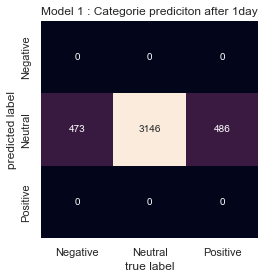

In [4]:

#1st model 1 day
X1 = final_1['Prepared comments'].tolist()
print('length X:', len(X1))
y1 = final_1['1day'].tolist()
print('length y:', len(y1))

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

model.fit(X_train, y_train)
predicted = model.predict(X_test)

mat = confusion_matrix(y_test, predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Model 1 : Categorie prediciton after 1day')
plt.savefig('model_1day.png')

print('model 1 score :', model.score(X_test, y_test))


model 2 score : 0.7113276492082826


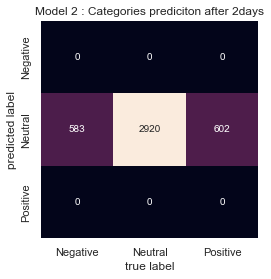

In [5]:

#2nd model 2 days
X2 = final_2['Prepared comments'].tolist()
y2 = final_2['2days'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.2, random_state=42)

model.fit(X_train, y_train)
predicted = model.predict(X_test)

mat = confusion_matrix(y_test, predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Model 2 : Categories prediciton after 2days')
plt.savefig('model_2days.png')

print('model 2 score :', model.score(X_test, y_test))


model 3 score : 0.6721071863580999


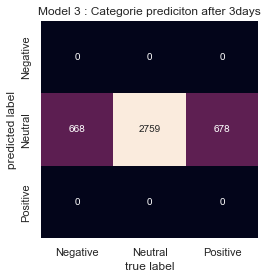

In [6]:

#3rd model 3 days
X3 = final_3['Prepared comments'].tolist()
y3 = final_3['3days'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size=0.2, random_state=42)

model.fit(X_train, y_train)
predicted = model.predict(X_test)

mat = confusion_matrix(y_test, predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Model 3 : Categorie prediciton after 3days')
plt.savefig('model_3days.png')

print('model 3 score :', model.score(X_test, y_test))


model 4 score : 0.6401948842874543


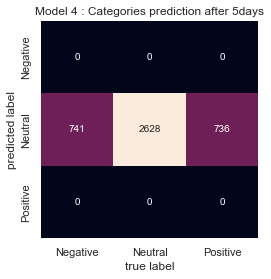

In [7]:

#4th model 5 days
X5 = final_5['Prepared comments'].tolist()
y5 = final_5['5days'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X5, y5, test_size=0.2, random_state=42)

model.fit(X_train, y_train)
predicted = model.predict(X_test)

mat = confusion_matrix(y_test, predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Model 4 : Categories prediction after 5days')
plt.savefig('model_5days.png')

print('model 4 score :', model.score(X_test, y_test))


model 5 score : 0.5624847746650427


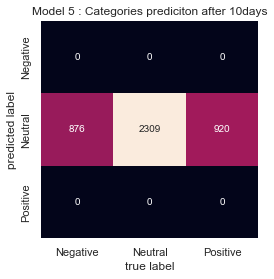

In [8]:

#5th model 10 days
X10 = final_10['Prepared comments'].tolist()
y10 = final_10['10days'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X10, y10, test_size=0.2, random_state=42)

model.fit(X_train, y_train)
predicted = model.predict(X_test)

mat = confusion_matrix(y_test, predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Model 5 : Categories prediciton after 10days')
plt.savefig('model_10days.png')
print('model 5 score :', model.score(X_test, y_test))


model 6 score : 0.5388550548112059


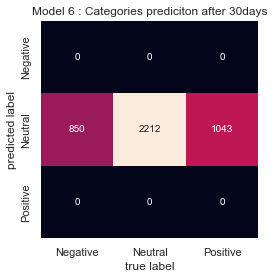

In [9]:

#6th model 30 days
X30 = final_30['Prepared comments'].tolist()
y30 = final_30['30days'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X30, y30, test_size=0.2, random_state=42)

model.fit(X_train, y_train)
predicted = model.predict(X_test)

mat = confusion_matrix(y_test, predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Model 6 : Categories prediciton after 30days')
plt.savefig('model_30days.png')

print('model 6 score :', model.score(X_test, y_test))


model 7 score : 0.43142509135200974


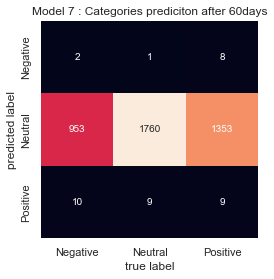

In [10]:

#7th model 60 days
X60 = final_60['Prepared comments'].tolist()
y60 = final_60['60days'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X60, y60, test_size=0.2, random_state=42)

model.fit(X_train, y_train)
predicted = model.predict(X_test)

mat = confusion_matrix(y_test, predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Model 7 : Categories prediciton after 60days')
plt.savefig('model_60days.png')

print('model 7 score :', model.score(X_test, y_test))


model 8 score : 0.4024360535931791


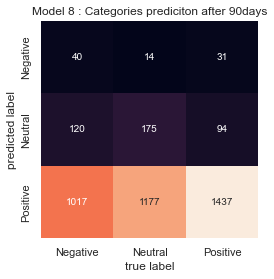

In [11]:

#8th model 90 days
X90 = final_90['Prepared comments'].tolist()
y90 = final_90['90days'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X90, y90, test_size=0.2, random_state=42)

model.fit(X_train, y_train)
predicted = model.predict(X_test)

mat = confusion_matrix(y_test, predicted)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Model 8 : Categories prediciton after 90days')
plt.savefig('model_90days.png')

print('model 8 score :', model.score(X_test, y_test))